## Transfer Learning (Tensorflow + VGG16 + CIFAR10)
The code below performs a complete task of transfer learning. All of it was made thinking of an easy way to learn this subject and an easy way to modify it in order to resolve other tasks.


---
Forked from https://github.com/clebeson/Deep_Learning/blob/master/Transfer-Learning/Transferlearning.ipynb

---

###All the necessary imports
Note that this code was made for running on [Google Colab](https://colab.research.google.com/notebooks/welcome.ipynb). Then, its usage outside this plataform requires adaptations. As taking off all the Google Colab dependencies and download manually the VGG16 model and put it into the folder "./model". The model can be downloaded [here](https://github.com/ry/tensorflow-vgg16/blob/master/vgg16-20160129.tfmodel.torrent):

In [1]:
%matplotlib inline  
import pickle
import numpy as np
import os
from urllib.request import urlretrieve
import tarfile
import zipfile
import sys
import tensorflow as tf
import numpy as np
from time import time
import skimage as sk
from skimage import transform
from skimage import util
import random
import math
import os.path
from random import shuffle
import logging
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
# from google.colab import files
from itertools import product
# !pip install googledrivedownloader
logging.getLogger("tensorflow").setLevel(logging.ERROR)
   

---
### Class that defines the principals hyperparameters used by the model


In [2]:
class Hyperparameters:
  def __init__(self):
      self.image_size = 32
      self.image_channels = 3
      self.num_classes = 10
      self.initial_learning_rate = 1e-4
      self.decay_steps = 1e3
      self.decay_rate = 0.98
      self.cut_layer = "pool5"
      self.hidden_layers = [512]
      self.batch_size = 128
      self.num_epochs = 200
      self.check_points_path= "./tensorboard/cifar10_vgg16"
      self.keep = 1.0
      self.fine_tunning = False
      self.bottleneck = True


### Class that  provides same utilities for the model, such as downloads files,  gets dataset, does  data augmentation,  generates bottlenecks files and creates a confusion matrix from the model.

In [3]:
class utils:
      def get_or_generate_bottleneck( sess, model, file_name, dataset, labels, batch_size = 128):

          path_file = os.path.join("./data_set",file_name+".pkl")
          if(os.path.exists(path_file)):
                print("Loading bottleneck from \"{}\" ".format(path_file))
                with open(path_file, 'rb') as f:
                   return pickle.load(f)

          bottleneck_data = []
          original_labels = []

          print("Generating Bottleneck \"{}.pkl\" ".format(file_name) )
          count = 0
          amount = len(labels) // batch_size
          indices = list(range(len(labels)))
          for i in range(amount+1):

                if (i+1)*batch_size < len(indices):
                  indices_next_batch = indices[i*batch_size: (i+1)*batch_size]
                else:
                   indices_next_batch = indices[i*batch_size:]
                batch_size = len(indices_next_batch)

                data = dataset[indices_next_batch]
                label = labels[indices_next_batch]
                input_size = np.prod(model["bottleneck_tensor"].shape.as_list()[1:])
                tensor = sess.run(model["bottleneck_tensor"], feed_dict={model["images"]:data, model["bottleneck_input"]:np.zeros((batch_size,input_size)), model["labels"]:label,model["keep"]:1.0})
                for t in range(batch_size):
                  bottleneck_data.append(np.squeeze(tensor[t]))
                  original_labels.append(np.squeeze(label[t]))
          
          bottleneck = {
              "data":np.array(bottleneck_data),
              "labels":np.array(original_labels)
          } 
          
          with open(path_file, 'wb') as f:
            pickle.dump(bottleneck, f)


          print("Done")   

          return bottleneck

      def get_data_set(name="train"):
          x = None
          y = None
          folder_name = 'cifar_10'
          main_directory = "./data_set"
          url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

          utils.maybe_download_and_extract(url, main_directory,folder_name, "cifar-10-batches-py")


          f = open(os.path.join(main_directory,folder_name,"batches.meta"), 'rb')
          f.close()

          if name is "train":
              for i in range(5):
                  f = open('./data_set/'+folder_name+'/data_batch_' + str(i + 1), 'rb')
                  datadict = pickle.load(f, encoding='latin1')
                  f.close()

                  _X = datadict["data"]
                  _Y = datadict['labels']

                  _X = np.array(_X, dtype=float) / 255.0
                  _X = _X.reshape([-1, 3, 32, 32])
                  _X = _X.transpose([0, 2, 3, 1])

                  if x is None:
                      x = _X
                      y = _Y
                  else:
                      x = np.concatenate((x, _X), axis=0)
                      y = np.concatenate((y, _Y), axis=0)

          elif name is "test":
              f = open('./data_set/'+folder_name+'/test_batch', 'rb')
              datadict = pickle.load(f, encoding='latin1')
              f.close()

              x = datadict["data"]
              y = np.array(datadict['labels'])

              x = np.array(x, dtype=float) / 255.0
              x = x.reshape([-1, 3, 32, 32])
              x = x.transpose([0, 2, 3, 1])

          return x, utils._dense_to_one_hot(y)


      def _dense_to_one_hot( labels_dense, num_classes=10):
          num_labels = labels_dense.shape[0]
          index_offset = np.arange(num_labels) * num_classes
          labels_one_hot = np.zeros((num_labels, num_classes))
          labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1

          return labels_one_hot


      


      def maybe_download_and_extract( url, main_directory,filename, original_name):
          def _print_download_progress( count, block_size, total_size):
            pct_complete = float(count * block_size) / total_size
            msg = "\r --> progress: {0:.1%}".format(pct_complete)
            sys.stdout.write(msg)
            sys.stdout.flush()
          
          if not os.path.exists(main_directory):
              os.makedirs(main_directory)
              url_file_name = url.split('/')[-1]
              zip_file = os.path.join(main_directory,url_file_name)
              print("Downloading ",url_file_name)

              try:
                file_path, _ = urlretrieve(url=url, filename= zip_file, reporthook=_print_download_progress)
              except:
                os.system("rm -r "+main_directory)
                print("An error occurred while downloading: ",url)

                if(original_name == 'vgg16-20160129.tfmodel'):
                  print("This could be for a problem with github. We will try downloading from the Google Drive")
                  from google_drive_downloader import GoogleDriveDownloader as gdd

                  gdd.download_file_from_google_drive(file_id='1xJZDLu_TK_SyQz-SaetAL_VOFY7xdAt5',
                                                      dest_path='./models/vgg16-20160129.tfmodel',
                                                      unzip=False)
                else: print("This could be for a problem with the storage site. Try again later")
                return

              print("\nDownload finished.")
              if file_path.endswith(".zip"):
                  print( "Extracting files.")

                  zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
              elif file_path.endswith((".tar.gz", ".tgz")):
                  print( "Extracting files.")
                  tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
                  os.remove(file_path)

              os.rename(os.path.join(main_directory,original_name), os.path.join(main_directory,filename))
              print("Done.")
     
      def data_augmentation(images, labels):
        
          def random_rotation(image_array):
              # pick a random degree of rotation between 25% on the left and 25% on the right
              random_degree = random.uniform(-15, 15)
              return sk.transform.rotate(image_array, random_degree)

          def random_noise(image_array):
              # add random noise to the image
              return sk.util.random_noise(image_array)

          def horizontal_flip(image_array):
              # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
              return image_array[:, ::-1]
          print("Augmenting data...")
          aug_images = []
          aug_labels = []

          aug_images.extend( list(map(random_rotation, images)) )
          aug_labels.extend(labels)
          aug_images.extend( list(map(random_noise,    images)) )
          aug_labels.extend(labels)
          aug_images.extend( list(map(horizontal_flip, images)) )
          aug_labels.extend(labels)


          return np.array(aug_images), np.array(aug_labels)
        
        
        
      
      def generate_confusion_matrix( predictions, class_names):
        
        def plot_confusion_matrix(cm, classes,
                                    normalize=False,
                                    title='Confusion matrix',
                                    cmap=plt.cm.Blues):
                """
                This function prints and plots the confusion matrix.
                Normalization can be applied by setting `normalize=True`.
                """
                if normalize:
                    cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    print("Normalized confusion matrix")
                else:
                    print('Confusion matrix, without normalization')

                print(cm.shape)

                plt.imshow(cm, interpolation='nearest', cmap=cmap)
                plt.title(title)
                plt.colorbar()
                
                tick_marks = np.arange(len(classes))
               
          
                plt.xticks(tick_marks, classes, rotation=45)
                plt.yticks(tick_marks, classes)

                fmt = '.2f' if normalize else 'd'
                thresh = cm.max() / 2.
                symbol = "%" if normalize else ""
                for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
                    plt.text(j, i, format(cm[i, j], fmt)+symbol,
                            horizontalalignment="center",
                            color="white" if cm[i, j] > thresh else "black")

                plt.tight_layout()
                plt.ylabel('Real')
                plt.xlabel('Predicted')
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(predictions["labels"],predictions["classes"])
        np.set_printoptions(precision=2)
        

        # # Plot normalized confusion matrix
        plt.figure(figsize=(10,7))
        plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                            title='Normalized confusion matrix')
        plt.grid('off')

        #plt.savefig("./confusion_matrix.png") #Save the confision matrix as a .png figure.
        plt.show()
#         

###The function "get_vgg16" returns a pretrained vgg16 model.

All the work of loading and restoring the weights of the model is responsibility of tensorflow. We just need to choose which layer we want to cut and pass it as parameter for the function "get_vgg16". In transfer learning it is common to dispose the fully connected layer and reuse only the convolutional ones. It occurs because the new problem/dataset used to be different from the original (such one that was used for training the model), and the numbers of classes is often different as well.

In a CNN, the first layers are responsible for selecting borders, the middle layers for selecting some kinds of patterns, based on combinations of those edges obtained previously and the last ones for composing patterns with a high level of representation, also known as semantic layers. Thereby, when the new dataset is much different of the original, the last layers are not indicated to be used. Since these ones likely represents particular patterns that will not help the new dataset. So, it is common to use the first layers in the transfer learning or fine tuning and add new fully connected ones in order to be trained from scratch.

In [4]:


def get_vgg16(input_images, cut_layer = "pool5", scope_name = "vgg16", fine_tunning = False):  
 
    file_name = 'vgg16-20160129.tfmodel'
    main_directory = "./models/"

    vgg_path = os.path.join(main_directory,file_name)
    if not os.path.exists(vgg_path):
        vgg16_url = "https://media.githubusercontent.com/media/pavelgonchar/colornet/master/vgg/tensorflow-vgg16/vgg16-20160129.tfmodel"
        utils.maybe_download_and_extract(vgg16_url, main_directory, file_name, file_name)


    with open(vgg_path, mode='rb') as f:
        content = f.read()
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(content)
        graph_def = tf.graph_util.extract_sub_graph(graph_def, ["images", cut_layer])
        tf.import_graph_def(graph_def, input_map={"images": input_images})
    del content

    graph = tf.get_default_graph()
    vgg_node = "import/{}:0".format(cut_layer) #It is possible to cut the graph in other node. 
                                               #For this, it is necessary to see the name of all layers by using the method 
                                               #"get_operations()": "print(graph.get_operations())" 


    vgg_trained_model = graph.get_tensor_by_name("{}/{}".format(scope_name, vgg_node) )

    if not fine_tunning:
      print("Stopping gradient")
      vgg_trained_model = tf.stop_gradient(vgg_trained_model) #Just use it in case of transfer learning without fine tunning


  #   print(graph.get_operations())
    return vgg_trained_model, graph


###Creating the model
The function  "transfer_learning_model" is responsible for creating the model that will be used for recognizing the CIFAR10 images.

The first scope ("placeholders_variables") defines:
* ** input images** -  the images that will feed the model
* **labels** - each image that feeds the input placeholder,  need to have a correspondent label, wich will feed this  placeholder when the loss was calculated.
* **dropout_keep** - it defines a percent of neurons that will not be activated in each fully connected layer. The number to be fed is between 0 and 1.
* **global_step** - As the train process is running, this variable stores the value of the current step. This value can be used for saving a checkpoint in an specific step, and, when restored, all the model continues the training process from this point/step.
* **learning rate** - it defines the learning rate to be used by the optimizer. In this case, the global step is used in order to provide a decay point even whether the training is restarted or not. It starts from an initial learning rate and decays according to an specific rate, with each number of steps.

These parameters are able to  influence directly the success of the training, so they are defined as hyperparameters of the model (class "Hyperparameters"), and must be treated and chosen carefully.


In [5]:
def transfer_learning_model(params = None, fine_tunning = False, bottleneck = False):
   
    if params is None:
       params = Hyperparameters()
      
    with tf.name_scope('placeholders_variables'):
        input_images = tf.placeholder(tf.float32, shape=[None,params.image_size, params.image_size, params.image_channels], name='input')
        labels = tf.placeholder(tf.float32, shape=[None, params.num_classes], name='labels')
        dropout_keep  =  tf.placeholder(tf.float32, name='dropout_keep')
        global_step = tf.train.get_or_create_global_step()
        learning_rate = tf.train.exponential_decay(params.initial_learning_rate, global_step, 
                                               params.decay_steps,params.decay_rate, staircase=True)       
    

    with tf.name_scope('vgg16'):
       # Create a VGG16 model and reuse its weights.
        vgg16_out,_ = get_vgg16(input_images=input_images,cut_layer = params.cut_layer, fine_tunning = fine_tunning)

    with tf.name_scope("flatten"):
        flatten = tf.layers.flatten(vgg16_out, name="flatten")
    
    if (not fine_tunning) and bottleneck:
        out_list = flatten.shape.as_list()
        BOTTLENECK_TENSOR_SIZE = np.prod(out_list[1:]) # All input layer size, less the batch size
        with tf.name_scope('bottleneck'):
            bottleneck_tensor = flatten
            bottleneck_input = tf.placeholder(tf.float32,
            shape=[None, BOTTLENECK_TENSOR_SIZE],
            name='InputPlaceholder')

        with tf.name_scope('fully_conn'):
             logits = fc_model(bottleneck_input, params.hidden_layers) #Create a fully connected model that will be fed by the bottleneck
    
    else:
        with tf.name_scope('fully_conn'):
             logits = fc_model(flatten, params.hidden_layers) #Create a fully connected model that will be fed by the vgg16

        

    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
#         loss = regularize(loss)
        tf.summary.scalar("loss", loss)


    with tf.name_scope('sgd'):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    with tf.name_scope('train_accuracy'):
        acc = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        acc = tf.reduce_mean(tf.cast(acc, tf.float32))
        tf.summary.scalar("accuracy", acc)
   
    
    predictions = {
                   "classes": tf.argmax(logits, 1),
                   "probs" :  tf.nn.softmax(logits), 
                   "labels": tf.argmax(labels, 1)
                   }
    model = {
              "global_step": global_step,
              "images": input_images,
              "labels": labels,    
              "loss" : loss,
              "optimizer": optimizer,
              "accuracy": acc,
              "predictions":predictions,
              "keep": dropout_keep
          }

    
    if (not fine_tunning) and bottleneck:
        model.update({"bottleneck_tensor":bottleneck_tensor})
        model.update({"bottleneck_input":bottleneck_input})
          
    return model
        
def get_fc_weights(w_inputs, w_output, id=0):
    weight= tf.Variable(tf.truncated_normal([w_inputs, w_output]), name="{}/weight".format(id))
    bias =  tf.Variable(tf.truncated_normal([w_output]), name="{}/bias".format(id))
    return weight, bias  

def logits_layer(fc_layer, n_classes):
    out_shape = fc_layer.shape.as_list()
    w, b = get_fc_weights(np.prod(out_shape[1:]), n_classes, "logits/weight")
    logits = tf.add(tf.matmul(fc_layer, w), b, name="logits")
    return logits
      
def fc_layer(input_layer, number_of_units, keep = None, layer_id = "fc"):
    pl_list = input_layer.shape.as_list()
    input_size = np.prod(pl_list[1:])

    w, b = get_fc_weights(input_size, number_of_units, layer_id)  
    fc_layer = tf.matmul(input_layer, w, name="{}/matmul".format(layer_id))
    fc_layer = tf.nn.bias_add(fc_layer, b, name="{}/bias-add".format(layer_id))

    if keep is not None:
      fc_layer = tf.nn.dropout(fc_layer, keep, name="{}/dropout".format(layer_id))
    else:
      print("Dropout was disabled.")

    fc_layer = tf.nn.relu(fc_layer, name="{}/relu".format(layer_id))
    return fc_layer
      
def regularize(loss, type = 1, scale = 0.005, scope = None):
    if type == 1:
        regularizer = tf.contrib.layers.l1_regularizer( scale=scale, scope=scope)
    else:
        regularizer = tf.contrib.layers.l2_regularizer( scale=scale, scope=scope)

    weights = tf.trainable_variables() # all vars of your graph
    regularization_penalty = tf.contrib.layers.apply_regularization(regularizer, weights)
    regularized_loss = loss + regularization_penalty
    return regularized_loss

def fc_model(flatten, hidden_layers = [512], keep = None):
    fc = flatten
    id = 1
    for num_neurons in hidden_layers:
      fc = fc_layer(fc, num_neurons, keep,  "fc{}".format(id) )
      id = id+1

    logits = logits_layer(fc, params.num_classes)
    return logits
    

### Creating a session
The function "create_monitored_session" creates a tensorflow session able to restore weights and/or save them. The parameter "checkpoint_dir" represents where the weights were saved or where one wants to save them. All the save/restore process is performed automatically by tensorflow.

As default, tensorflow allocates all GPU memory in the first called to the session run, thus the "tf.ConfigProto()", by setting the "True" to the "gpu_options.allow_growth", allows the gradual increasing of memory. In other words, it allows to allocate the GPU memory by demanding. This is  important mainly when more than one training or prediction process is running on the same GPU.


In [6]:
def create_monitored_session(model,iter_per_epoch, checkpoint_dir):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True


    sess = tf.train.MonitoredTrainingSession(checkpoint_dir=checkpoint_dir,
                                        save_checkpoint_secs=120,
                                        log_step_count_steps=iter_per_epoch,
                                        save_summaries_steps=iter_per_epoch,
                                        config=config) 
    return sess

### Testing the model
The function "test" is responsible for applying the test dataset through the trained model. Thus, it is possible to monitor the model progress. This function could be change in order to do a validation test, which uses the validation dataset,  rather than just a test. It would be helpful for problems that do not release a labeled test dataset.

In [7]:
def test(sess, model,input_data_placeholder, data, labels, batch_size = 128):
    global_accuracy = 0
    predictions = {
                   "classes":[],
                   "probs":[],
                   "labels":[]
                  }

    size = len(data)//batch_size
    indices = list(range(len(data)))

    for i in range(size+1):

        begin = i*batch_size
        end = (i+1)*batch_size
        end = len(data) if end >= len(data) else end

        next_bach_indices = indices[begin:end]
        batch_xs = data[next_bach_indices]
        batch_ys = labels[next_bach_indices]

        pred = sess.run(model["predictions"],
            feed_dict={input_data_placeholder: batch_xs, model["labels"]: batch_ys, model["keep"]:1.0})

        predictions["classes"].extend(pred["classes"])
        predictions["probs"].extend(pred["probs"])
        predictions["labels"].extend(pred["labels"])


    correct = list (map(lambda x,y: 1 if x==y else 0, predictions["labels"] , predictions["classes"]))
    acc = np.mean(correct ) *100

    mes = "--> Test accuracy: {:.2f}% ({}/{})"
    print(mes.format( acc, sum(correct), len(data)))

    return predictions


###Training the model: the mainly function
The "train" function is responsible for training the model. It starts checking the hyperparameters and resetting the default graph.  Then, the dataset is loaded by using the class "util". The next step consists of  creating the model, where the tensorflow graph is created. Now, a monitored season is created too. This kind of session will save and restore the model automatically, which will be very important when an unexpected event occurs and the model stop the training (such as a power outage or when the Google Colab finishes the session during the training).

With the model and the session created, you are able, if you want, to generate or load the bottlenecks files. This is what the next lines are doing. One of the most important results of theses lines is  obtaining the tensor "input_data_placeholder". It is important because when the bottleneck option is chosen, the "feed_dict" must feed the placeholder of the "bottleneck" rather than the one that feeds the VVG16 inputs. Thus, if the bottleneck is chosen, the input placeholder will be the "model[bottleneack_input]", else, it will be the input tensor of the vgg16, "model[images]".

In the  the beginning of each epoch, in order to ensure the randomness of the baths,  a list containing the dataset indices is shuffled. So, at every batch, a new range of indices is taken and the batch may feed the placeholder.

Therefore, the session can call the optimizer and train the model. Finally, the last two steps consiste of calling the test funtion for checking the training result every epoch, and generate a confusion matrix with the result of the last one.


In [8]:
def train(params = None):
    if params is None:
      params = Hyperparameters()
      
    tf.reset_default_graph()

    train_data, train_labels = utils.get_data_set("train")
    train_data, train_labels = utils.data_augmentation(train_data, train_labels)
    
    test_data, test_labels = utils.get_data_set("test")  
    
    model = transfer_learning_model(params, params.fine_tunning, params.bottleneck)
   
    steps_per_epoch = int(math.ceil(len(train_data) /  params.batch_size))
    sess = create_monitored_session(model,steps_per_epoch, params.check_points_path)
    
    
    if (not params.fine_tunning) and params.bottleneck:
        indices = list( range(len(train_data)) )
        shuffle(indices)
        
        shuffled_data = train_data[indices]
        shuffled_labels = train_labels[indices]
        
        bottleneck_train = utils.get_or_generate_bottleneck(sess, model, "bottleneck_vgg16_{}_train".format(params.cut_layer), shuffled_data, shuffled_labels)
        bottleneck_test = utils.get_or_generate_bottleneck(sess, model, "bottleneck_vgg16_{}_test".format(params.cut_layer), test_data, test_labels)
        
        train_data, train_labels  = bottleneck_train["data"], bottleneck_train["labels"]
        test_data, test_labels = bottleneck_test["data"], bottleneck_test["labels"]
        del bottleneck_train, bottleneck_test
        
        input_data_placeholder = model["bottleneck_input"]
        
    else:
        input_data_placeholder = model["images"]
        
        
    
    indices = list( range(len(train_data)) )
    msg = "--> Global step: {:>5} - Last batch acc: {:.2f}% - Batch_loss: {:.4f} - ({:.2f}, {:.2f}) (steps,images)/sec"
    
    for epoch in range(params.num_epochs):
        start_time = time()
        
        print("\n*************************************************************")
        print("Epoch {}/{}".format(epoch+1,params.num_epochs))
        
        shuffle(indices)  
        for s in range(steps_per_epoch):
          
            indices_next_batch = indices[s *  params.batch_size : (s+1) * params.batch_size]
            batch_data = train_data[indices_next_batch]
            batch_labels = train_labels[indices_next_batch]
            
            _, batch_loss, batch_acc,step = sess.run(
                [model["optimizer"], model["loss"], model["accuracy"], model["global_step"],],
                feed_dict={input_data_placeholder: batch_data, model["labels"]: batch_labels, model["keep"]:params.keep})
        
        duration = time() - start_time

        print(msg.format(step,  batch_acc*100, batch_loss, (steps_per_epoch / duration), (steps_per_epoch*params.batch_size / duration) ))

        
        _ = test(sess, model, input_data_placeholder, test_data, test_labels )
    
    predictions = test(sess, model, input_data_placeholder, test_data, test_labels )

    sess.close()
    
    class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"] 
    utils.generate_confusion_matrix(predictions, class_names)

This part of code instantiates a "Hyperparameters" class, changes it and passes it as parameter to the train function. Thus, the training can be started.

 --> progress: 100.0%
Download finished.
Extracting files.
Done.
Augmenting data...
 --> progress: 7.8%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 --> progress: 100.0%
Download finished.
Done.
Stopping gradient
Dropout was disabled.
Generating Bottleneck "bottleneck_vgg16_pool4_train.pkl" 
Done
Generating Bottleneck "bottleneck_vgg16_pool4_test.pkl" 
Done

*************************************************************
Epoch 1/100
--> Global step:  1171 - Last batch acc: 58.93% - Batch_loss: 26803.2461 - (1.56, 199.93) (steps,images)/sec
--> Test accuracy: 68.24% (6824/10000)

*************************************************************
Epoch 2/100
--> Global step:  2343 - Last batch acc: 75.89% - Batch_loss: 13272.5469 - (312.84, 40044.15) (steps,images)/sec
--> Test accuracy: 70.58% (7058/10000)

*************************************************************
Epoch 3/100
--> Global step:  3515 - Last batch acc: 72.32% - Batch_loss: 10897.7207 - (328.60, 42060.46) (steps,images)/sec
--> Test accuracy: 71.93% (7193/10000)

*************************************************************
Epoch 4/100
--> Global step:  4687 - Last batch 

--> Global step: 42191 - Last batch acc: 100.00% - Batch_loss: 0.0000 - (337.12, 43151.34) (steps,images)/sec
--> Test accuracy: 76.71% (7671/10000)

*************************************************************
Epoch 37/100
--> Global step: 43363 - Last batch acc: 99.11% - Batch_loss: 14.1221 - (333.97, 42748.48) (steps,images)/sec
--> Test accuracy: 76.13% (7613/10000)

*************************************************************
Epoch 38/100
--> Global step: 44535 - Last batch acc: 98.21% - Batch_loss: 75.1741 - (338.80, 43366.49) (steps,images)/sec
--> Test accuracy: 76.88% (7688/10000)

*************************************************************
Epoch 39/100
--> Global step: 45707 - Last batch acc: 99.11% - Batch_loss: 22.3431 - (323.47, 41403.58) (steps,images)/sec
--> Test accuracy: 76.85% (7685/10000)

*************************************************************
Epoch 40/100
--> Global step: 46879 - Last batch acc: 100.00% - Batch_loss: 0.0000 - (321.77, 41186.76) (steps,im

--> Global step: 85555 - Last batch acc: 100.00% - Batch_loss: 0.0000 - (313.92, 40181.85) (steps,images)/sec
--> Test accuracy: 77.58% (7758/10000)

*************************************************************
Epoch 74/100
--> Global step: 86727 - Last batch acc: 100.00% - Batch_loss: 0.0000 - (314.64, 40273.68) (steps,images)/sec
--> Test accuracy: 77.38% (7738/10000)

*************************************************************
Epoch 75/100
--> Global step: 87899 - Last batch acc: 100.00% - Batch_loss: 0.0000 - (302.06, 38663.40) (steps,images)/sec
--> Test accuracy: 76.92% (7692/10000)

*************************************************************
Epoch 76/100
--> Global step: 89071 - Last batch acc: 100.00% - Batch_loss: 0.0000 - (315.16, 40340.79) (steps,images)/sec
--> Test accuracy: 77.15% (7715/10000)

*************************************************************
Epoch 77/100
--> Global step: 90243 - Last batch acc: 100.00% - Batch_loss: 0.0000 - (317.72, 40668.10) (steps,im

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


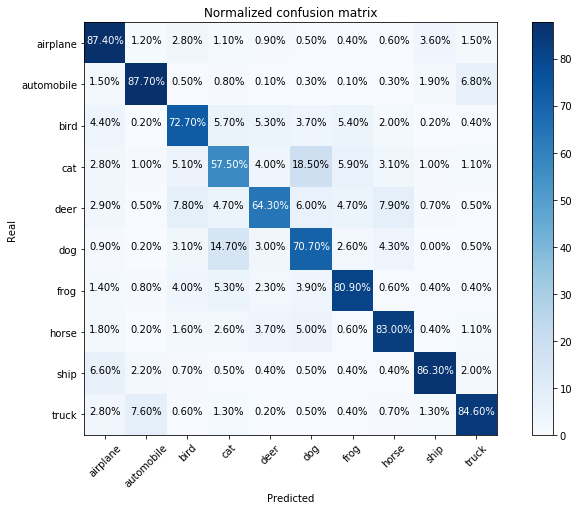

In [9]:
if __name__ == "__main__":
  params = Hyperparameters()
  params.num_epochs = 100
  params.hidden_layers = [1024]
  params.initial_learning_rate = 1e-3
  params.cut_layer = "pool4"

  train(params)
